# Setup

In [1]:
%matplotlib inline

/Volumes/Home/venvs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:281: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


In [2]:
import logging
logging.basicConfig(level=logging.INFO)

In [42]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn.ensemble
import sklearn.linear_model
import sklearn.metrics
import sklearn.pipeline

from IPython.display import display, Markdown

from chmp.ds import (
    reload, mpl_set,
    FuncTransformer, FilterLowFrequencyTransfomer, OneHotEncoder, DataFrameEstimator, 
    find_categorical_columns,
)
from chmp.experiment import loop

reload(
    'chmp.app.off_policy.model.evaluation', 
    'chmp.app.off_policy.model.models', 
    'chmp.app.off_policy.model.util', 
    'chmp.app.off_policy.model',
)

from chmp.app.off_policy.dataset import census
from chmp.app.off_policy.model import (
    action_p_to_propensity, 
    build_standard_sklearn_classifier,
    evaluate,
    
    BinaryOutcomeRegressionPolicy, 
    DirectClassifierPolicy,
)

In [5]:
_logger = logging.getLogger(__name__)

# Dataset Overview

## Census Data

Generated by classification -> partially labelled transformation.

- Original target `target`
- Action variable `action`
- Outcome for classification `outcome` 
- Outcome for regression `value`

In [14]:
data_census = pd.read_parquet('./data/census.parquet')
for col, typ in census.columns:
    data_census = data_census.assign(**{col: data_census[col].astype(typ)})

data_census['propensity'] = action_p_to_propensity(data_census['action'], data_census['action_p'])

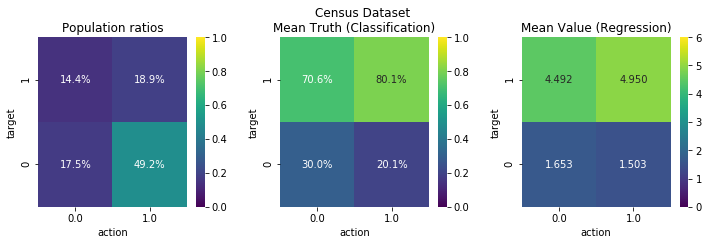

In [15]:
plt.figure(figsize=(12, 3.25))
mpl_set(top=0.85, wspace=0.3, suptitle='Census Dataset')

plt.subplot(1, 3, 1)
sns.heatmap(
    data_census.groupby(['target', 'action']).size().pipe(lambda s: s / s.sum()).unstack(),
    vmin=0, vmax=1, cmap='viridis', annot=True, fmt='.1%',
)
mpl_set(title='Population ratios', invert='y')

plt.subplot(1, 3, 2)
sns.heatmap(
    data_census.groupby(['target', 'action'])['outcome'].mean().unstack(),
    vmin=0, vmax=1, cmap='viridis', annot=True, fmt='.1%',
)
mpl_set(title='Mean Truth (Classification)', invert='y')

plt.subplot(1, 3, 3)
sns.heatmap(
    data_census.groupby(['target', 'action'])['value'].mean().unstack(),
    vmin=0, vmax=6, cmap='viridis', annot=True, fmt='.3f',
)
mpl_set(title='Mean Value (Regression)', invert='y')
pass

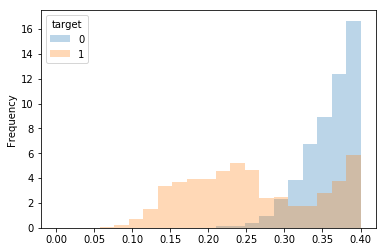

In [16]:
(
    data_census
    .query('target == 0')
    ['action_p']
    .plot.hist(normed=True, alpha=0.3, range=(0, 0.4), bins=21, ax=plt.gca(), label='0')
)
(
    data_census
    .query('target == 1')
    ['action_p']
    .plot.hist(normed=True, alpha=0.3, range=(0, 0.4), bins=21, ax=plt.gca(), label='1')
)
plt.legend(loc='best', title='target')
pass

In [17]:
# prep training ...
data_census_train = data_census.query('train == 1').copy().reset_index(drop=True)
data_census_test = data_census.query('train == 0').copy().reset_index(drop=True)
data_census_train['weight_true'] = (
    (data_census_train['action'] == 0) / (1 - data_census_train['action_p']) +
    (data_census_train['action'] == 1) / data_census_train['action_p']
)

print(f'train size: {len(data_census_train):,d}, test size: {len(data_census_test):,d}')

train size: 199,786, test size: 99,498


# Model Comparison

In [44]:
estimators = [
    ('regression', BinaryOutcomeRegressionPolicy(
        build_standard_sklearn_classifier(census.features + ['action']),
    )),
    ('direct', DirectClassifierPolicy(
        build_standard_sklearn_classifier(census.features),
        propensity_column='propensity',
    )),
]

In [45]:
metrics = []

for label, est in loop(estimators):
    est.fit(data_census_train)
    
    metrics.append(evaluate(
        est, data_census_train, 
        value_columns=['outcome_0_p_det', 'outcome_1_p_det'],
        propensity_column='propensity',
        label=f'{label} (train)',
    ))
    metrics.append(evaluate(
        est, data_census_test, 
        value_columns=['outcome_0_p_det', 'outcome_1_p_det'],
        propensity_column='propensity',
        label=f'{label} (test)',
    ))

INFO:chmp.app.off_policy.model.evaluation:predict
INFO:chmp.app.off_policy.model.evaluation:run evaluations
INFO:chmp.app.off_policy.model.evaluation:predict
INFO:chmp.app.off_policy.model.evaluation:run evaluations


INFO:chmp.app.off_policy.model.evaluation:predict
INFO:chmp.app.off_policy.model.evaluation:run evaluations
INFO:chmp.app.off_policy.model.evaluation:predict
INFO:chmp.app.off_policy.model.evaluation:run evaluations


[⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿ 6m 33s / 7m 5s]                                                                                             


In [46]:
pd.DataFrame(metrics).set_index('label').transpose().drop(['value_plot'], axis=0)

label                regression (train) regression (test) direct (train)  \
best_guess_reward              0.467693          0.464203       0.431636   
dm_reward                      0.562156           0.55737       0.458772   
dr_reward                      0.466943          0.464333            NaN   
ips_reward                     0.467308          0.464386       0.435666   
mean_observed_reward           0.405159          0.403536       0.405159   
optimal_reward                 0.467825           0.46434       0.467825   
regret                     -0.000131641      -0.000136686     -0.0361881   
size                             199786             99498         199786   
snips_reward                    0.46591          0.463521       0.434043   
true_reward                    0.467693          0.464203       0.431636   
value_mad_0                   0.0152729         0.0150441            NaN   
value_mad_1                   0.0105084         0.0103935            NaN   

label                direct (test)  
best_guess_reward         0.428154  
dm_reward                 0.453894  
dr_reward                      NaN  
ips_reward                0.429631  
mean_observed_reward      0.403536  
optimal_reward             0.46434  
regret                   -0.036186  
size                         99498  
snips_reward              0.428898  
true_reward               0.428154  
value_mad_0                    NaN  
value_mad_1                    NaN